<a href="https://colab.research.google.com/github/sayanbanerjee32/TSAI_ERAv2_S7/blob/main/step3/S7_step3_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:

- Add image augmentation
- Add learning rate scheduler so that learning rate can be decreased when the loss gets plateaued

## Results:

- Parameters: 7432
- Best Training Accuracy: 98.86%
- Best Test Accuracy: 99.42%

## Analysis:

- Started with high learning rate so that loss gets reduced quickly in initail epochs. Learning rate is reduced at a later point using ReduceLROnPlateau for controlled convergence of loss.
- Image augmentation helped in increasing test accuracy compared to train accuracy.

# Import all required packages including local files

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

#import from local modules
from model_3 import Net
from utils import train, test, get_device, plot_accuracy_losses

# Check if GPU available

In [2]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Train and Test transformations

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                        transforms.Resize((28, 28)),
                                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [4]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 146501678.16it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 97926995.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44174910.07it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23147665.57it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 1, 28, 28])
torch.Size([128])


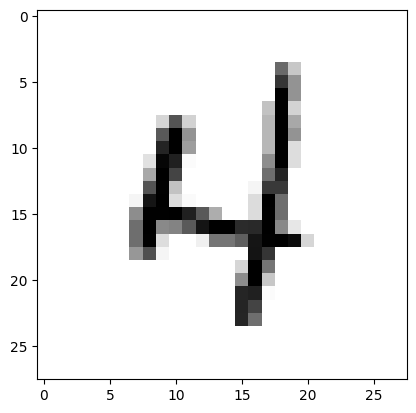

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

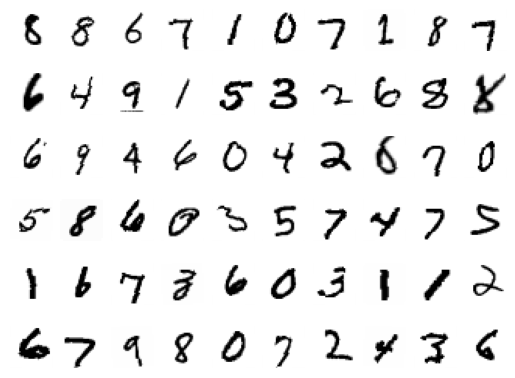

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Training

In [8]:
# class Net(nn.Module):
#     def __init__(self, n = 8, dropout_value = 0.1):
#         super(Net, self).__init__()
#         # # Input Block
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=n,
#                       kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(n),
#             nn.Dropout(dropout_value)
#         ) #input size: 28 x 28 x 1, output size: 26 x 26 x n, receptive field: 1 + (3-1) * 1 = 3

#         # CONVOLUTION BLOCK 1
#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=n, out_channels=n*2,
#                       kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(n*2),
#             nn.Dropout(dropout_value)
#         ) #input size: 26 x 26 x n, output size: 24 x 24 x n*2, receptive field: 3 + (3-1) * 1 = 5

#         # TRANSITION BLOCK 1
#         self.pool1 = nn.MaxPool2d(2, 2) #input size: 24 x 24 x n*2, output size: 12 x 12 x n*2, receptive field: 5 + (2-1) * 1 = 6
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=n*2, out_channels=n,
#                       kernel_size=(1, 1), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(n),
#             nn.Dropout(dropout_value)
#         ) #input size: 12 x 12 x n*2, output size: 12 x 12 x n, receptive field: 6 + (1-1)*2 = 6

#         # CONVOLUTION BLOCK 2
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=n, out_channels=n*2,
#                       kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(n*2),
#             nn.Dropout(dropout_value)
#         ) #input size: 12 x 12 x n, output size: 10 x 10 x n*2, receptive field: 6 + (3-1) * 2 = 10

#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=n*2, out_channels=n*2,
#                       kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(n*2),
#             nn.Dropout(dropout_value)
#         ) #input size: 10 x 10 x n*2, output size: 8 x 8 x n*2, receptive field: 10 + (3-1) * 2 = 14

#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=n*2, out_channels=n*2,
#                       kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(n*2),
#             nn.Dropout(dropout_value)
#         ) #input size: 8 x 8 x n*2, output size: 6 x 6 x n*2, receptive field: 14 + (3-1) * 2 = 18

#         # OUTPUT BLOCK
#         self.gap = nn.Sequential(
#             # nn.AvgPool2d(kernel_size=7) # 7>> 9...
#             nn.AdaptiveAvgPool2d((1, 1))
#         ) #input size: 6 x 6 x n*2, output size: 1 x 1 x n*2, receptive field: 18

#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=n*2, out_channels=10,
#                       kernel_size=(1, 1), padding=0, bias=False),
#             # nn.BatchNorm2d(10),
#             # nn.ReLU()
#         ) #input size: 1 x 1 x n*2, output size: 1 x 1 x 10, receptive field: 18 + (1-1) * 2 =18



#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)

#         x = self.pool1(x)
#         x = self.convblock3(x)

#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)

#         x = self.gap(x)
#         x = self.convblock7(x)

#         x = x.squeeze()

#         return F.log_softmax(x, dim=-1)

In [9]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [11]:
optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9) # reduce learning rate, loss not converging
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 2,
                                                 verbose=True)
criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    # print(f"learning rate={optimizer.state_dict()['param_groups'][0]['lr']}, trn_loss = {trn_loss}")



Epoch 1


Train: Loss=0.1784 Batch_id=468 Accuracy=90.11: 100%|██████████| 469/469 [00:40<00:00, 11.69it/s]


Test set: Average loss: 0.1062, Accuracy: 9720/10000 (97.20%)

Epoch 2


Train: Loss=0.1103 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:42<00:00, 11.08it/s]


Test set: Average loss: 0.0536, Accuracy: 9815/10000 (98.15%)

Epoch 3


Train: Loss=0.1535 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:41<00:00, 11.40it/s]


Test set: Average loss: 0.0516, Accuracy: 9845/10000 (98.45%)

Epoch 4


Train: Loss=0.0072 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:42<00:00, 11.06it/s]


Test set: Average loss: 0.0544, Accuracy: 9845/10000 (98.45%)

Epoch 5


Train: Loss=0.0854 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:42<00:00, 11.07it/s]


Test set: Average loss: 0.0331, Accuracy: 9892/10000 (98.92%)

Epoch 6


Train: Loss=0.0487 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:41<00:00, 11.32it/s]


Test set: Average loss: 0.0322, Accuracy: 9894/10000 (98.94%)

Epoch 7


Train: Loss=0.0648 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:41<00:00, 11.43it/s]


Test set: Average loss: 0.0285, Accuracy: 9911/10000 (99.11%)

Epoch 8


Train: Loss=0.0269 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:41<00:00, 11.27it/s]


Test set: Average loss: 0.0460, Accuracy: 9851/10000 (98.51%)

Epoch 9


Train: Loss=0.0678 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:40<00:00, 11.47it/s]


Test set: Average loss: 0.0312, Accuracy: 9904/10000 (99.04%)

Epoch 10


Train: Loss=0.0185 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:42<00:00, 11.05it/s]


Test set: Average loss: 0.0377, Accuracy: 9886/10000 (98.86%)

Epoch 00010: reducing learning rate of group 0 to 1.0000e-01.
Epoch 11


Train: Loss=0.0257 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:41<00:00, 11.21it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

Epoch 12


Train: Loss=0.1075 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:41<00:00, 11.29it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

Epoch 13


Train: Loss=0.1323 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:43<00:00, 10.70it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

Epoch 14


Train: Loss=0.0171 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:43<00:00, 10.75it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

Epoch 15


Train: Loss=0.0639 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:44<00:00, 10.50it/s]


Test set: Average loss: 0.0183, Accuracy: 9941/10000 (99.41%)



## Visualise training and test losses and accuracies

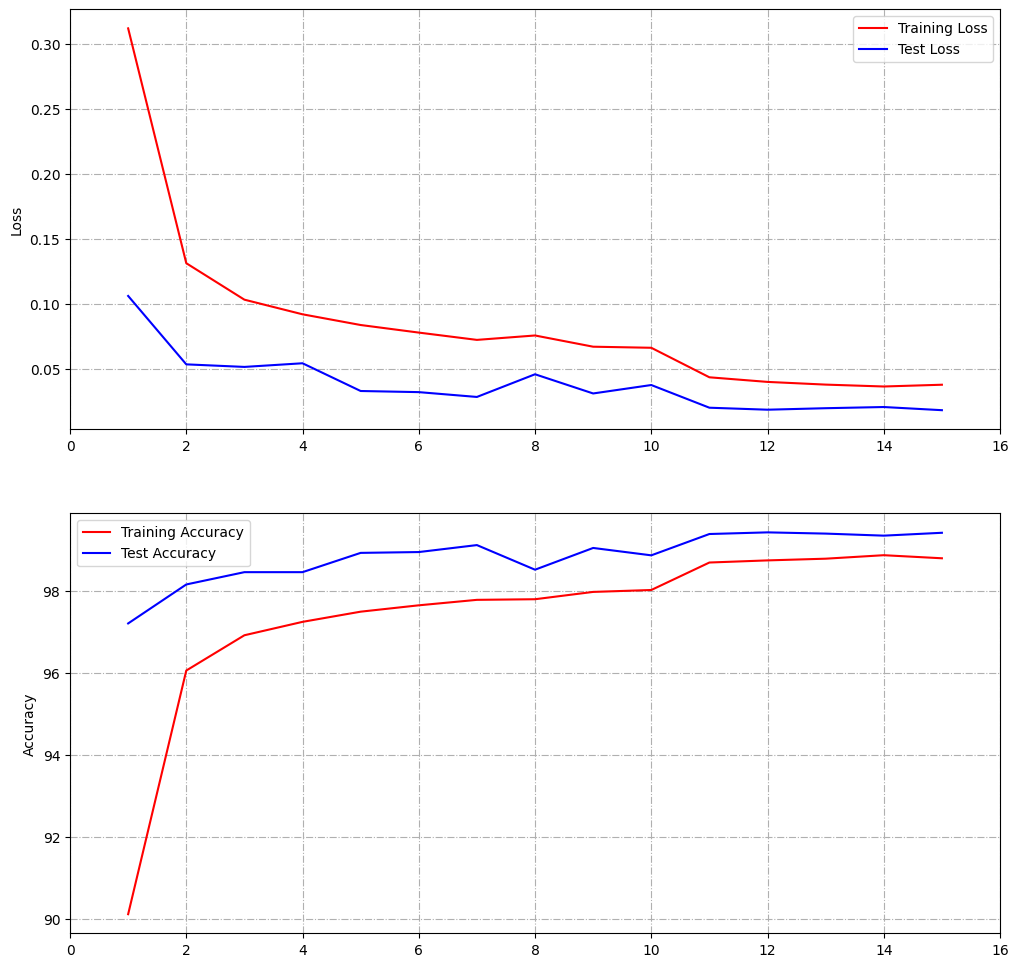

In [12]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, num_epochs)